### Setup (see ageron/handson-ml)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, re

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Get the data

In [2]:
import pandas as pd

SCOTCH_PATH = os.path.join("data")

def load_scotch_data(scotch_path="./data"):
    csv_path = os.path.join(scotch_path, "scotch_review.csv")
    return pd.read_csv(csv_path)

In [3]:
scotch=load_scotch_data()
scotch.head()

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [4]:
def get_alc(string):
    try:
        return float(re.findall(r'(?<!\%)(\d*\.\d|\d{1,2})',string)[-1])
    except:
        return np.nan    

In [5]:
def get_age(string):
    try:
        return float(re.findall(r'\d{1,2}(?=\syear)',string)[-1])
    except:
        return np.nan

In [6]:
def get_date(string,year_today=2020):
    try:
        return year_today-int(re.findall(r'(?<=\s)19\d{2}',string)[-1])
    except:
        return np.nan

In [7]:
def final_age(first,second):
    if first>0:
        return first
    else:
        return second

In [8]:
def get_price(string):
    try:
        return float(string)
    except:
        try:
            return float(re.findall(r'\d{1,10}\,\d{1,10}',string)[0].replace(',','.'))*1000
        except:
            return np.nan

In [9]:
scotch['Alc_%']=scotch['name'].progress_apply(get_alc)
scotch['Age_y_1']=scotch['name'].progress_apply(get_age)
scotch['Age_y_2']=scotch['name'].progress_apply(get_date)
scotch['Age_y']=scotch.progress_apply(lambda x: final_age(x['Age_y_1'],x['Age_y_2']),axis=1)
scotch['price']=scotch['price'].progress_apply(get_price)
scotch.drop('Unnamed: 0',axis=1,inplace=True)
scotch.drop('Age_y_1',axis=1,inplace=True)
scotch.drop('Age_y_2',axis=1,inplace=True)
scotch.head(20)

,name,category,review.point,price,currency,description,Alc_%,Age_y
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0,$,"Magnificently powerful and intense. Caramels, ...",40.0,NaN
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,$,What impresses me most is how this whisky evol...,40.5,42.0
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,$,There have been some legendary Bowmores from t...,42.9,46.0
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325.0,$,With a name inspired by a 1926 Buster Keaton m...,53.4,NaN
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160.0,$,"Captivating, enticing, and wonderfully charmin...",40.0,NaN
5,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.0,$,"Powerful, muscular, well-textured, and invigor...",57.1,NaN
6,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,$,Deep gold color. Surprisingly lively on the no...,42.4,56.0
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,$,"Definitely showing its age, but not in a bad w...",44.8,40.0
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,$,The Dalmore is one of a handful of whiskies th...,52.8,50.0
9,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360.0,$,A rich amber color and elegantly oxidized note...,47.2,66.0


In [10]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 8 columns):
name            2247 non-null object
category        2247 non-null object
review.point    2247 non-null int64
price           2246 non-null float64
currency        2247 non-null object
description     2247 non-null object
Alc_%           2242 non-null float64
Age_y           1565 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 140.6+ KB


In [11]:
scotch['category'].value_counts()

Single Malt Scotch            1819
Blended Scotch Whisky          211
Blended Malt Scotch Whisky     132
Single Grain Whisky             57
Grain Scotch Whisky             28
Name: category, dtype: int64

In [12]:
scotch.describe()

,review.point,price,Alc_%,Age_y
count,2247.000000,2246.000000,2242.000000,1565.000000
mean,86.700045,643.384239,47.769224,23.995527
std,4.054055,4703.661783,6.513113,11.764390
min,63.000000,12.000000,0.000000,3.000000
25%,84.000000,70.000000,43.000000,15.000000
50%,87.000000,110.000000,46.000000,22.000000
75%,90.000000,200.000000,52.100000,30.000000
max,97.000000,157000.000000,98.000000,70.000000


In [13]:
scotch[['name','category','review.point','price']].sort_values('review.point',ascending=False)[:10]

,name,category,review.point,price
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",Single Malt Scotch,96,1500.0
10,"The Glenlivet Cellar Collection, 1969 vintage,...",Single Malt Scotch,96,750.0
9,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360.0
12,The Last Drop (distilled at Lochside) 1972 (ca...,Grain Scotch Whisky,96,3108.0
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0
6,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0


### General visualizations

In [14]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


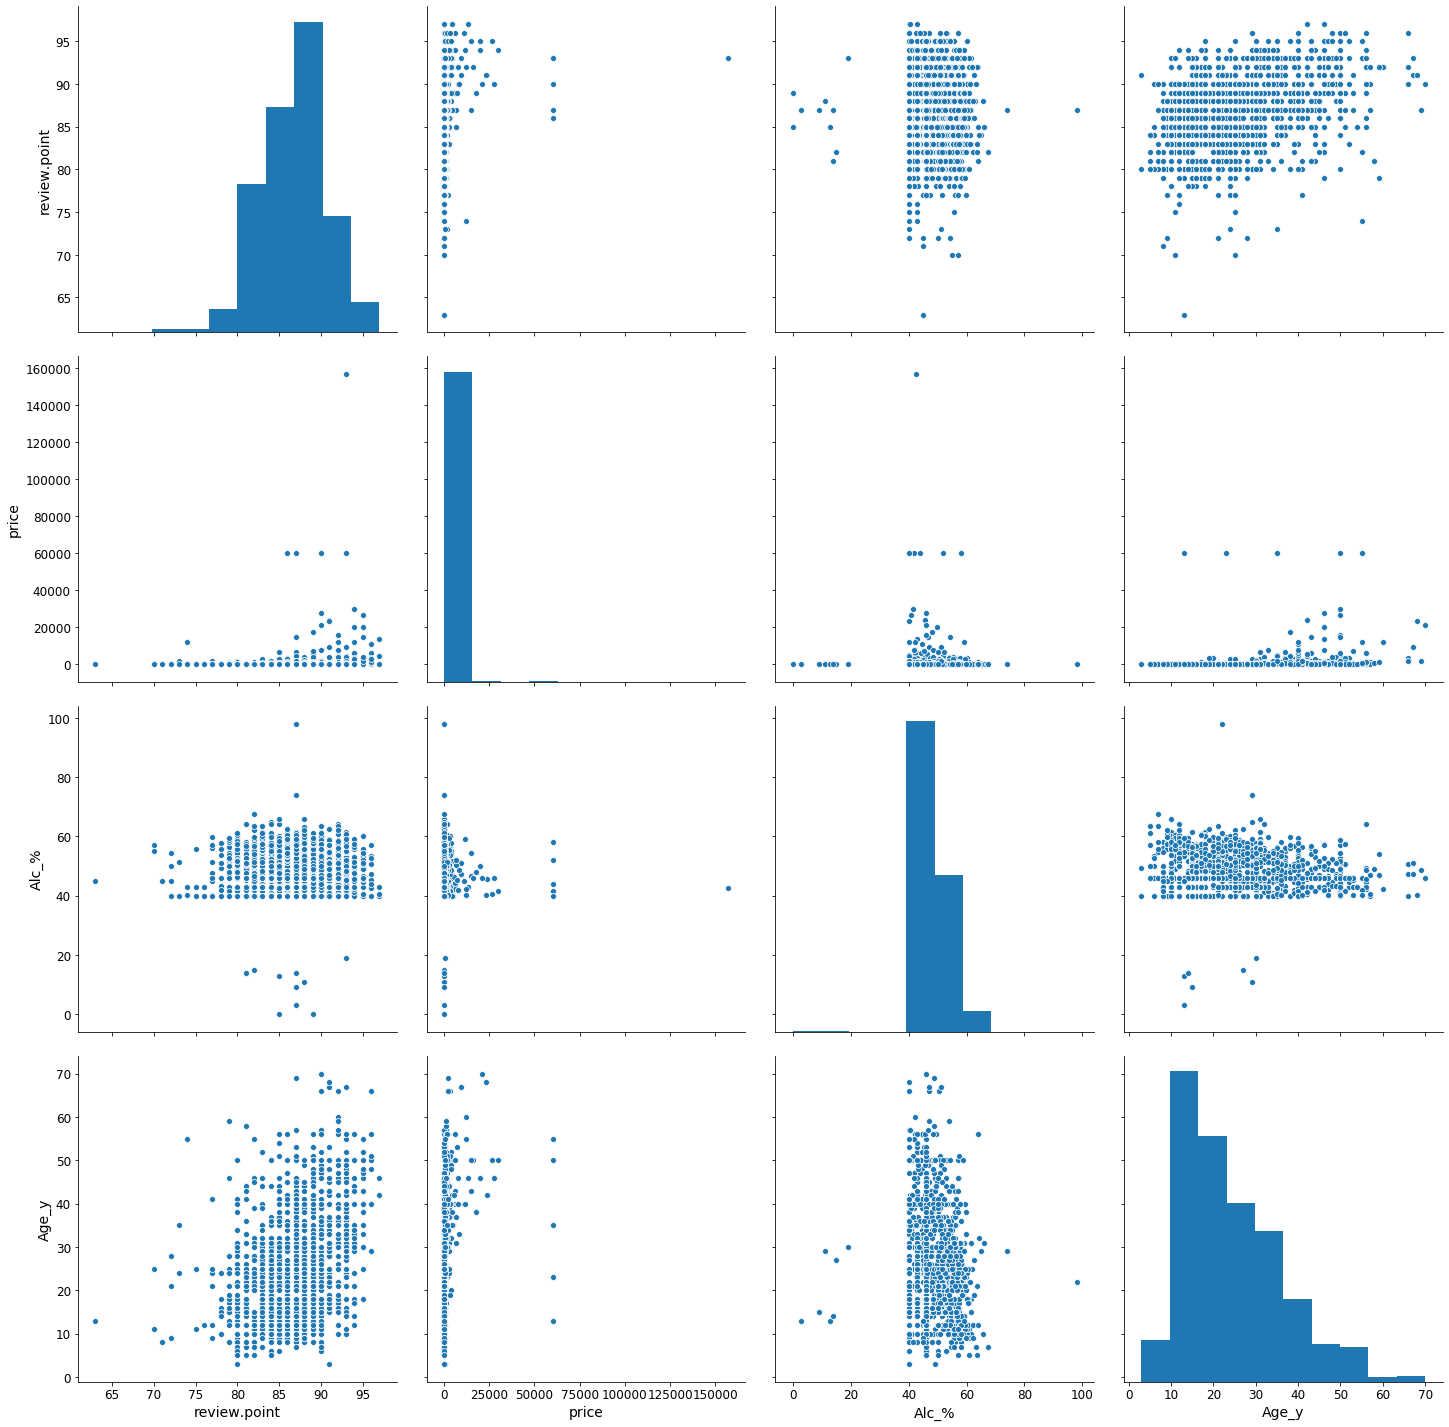

In [15]:
sns.pairplot(scotch, size=5)

Observations:
- what you first see is that there is a quite hard edge for alcohol % of 40;
- generally, the alcohol % is between 40% and ~65%, but there are a few outliers (e.g. <20%)
- there seems not to be a correlation between alcohol % and rating, but age and rating is + correlated
- price is quite hard to see; outliers are present

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


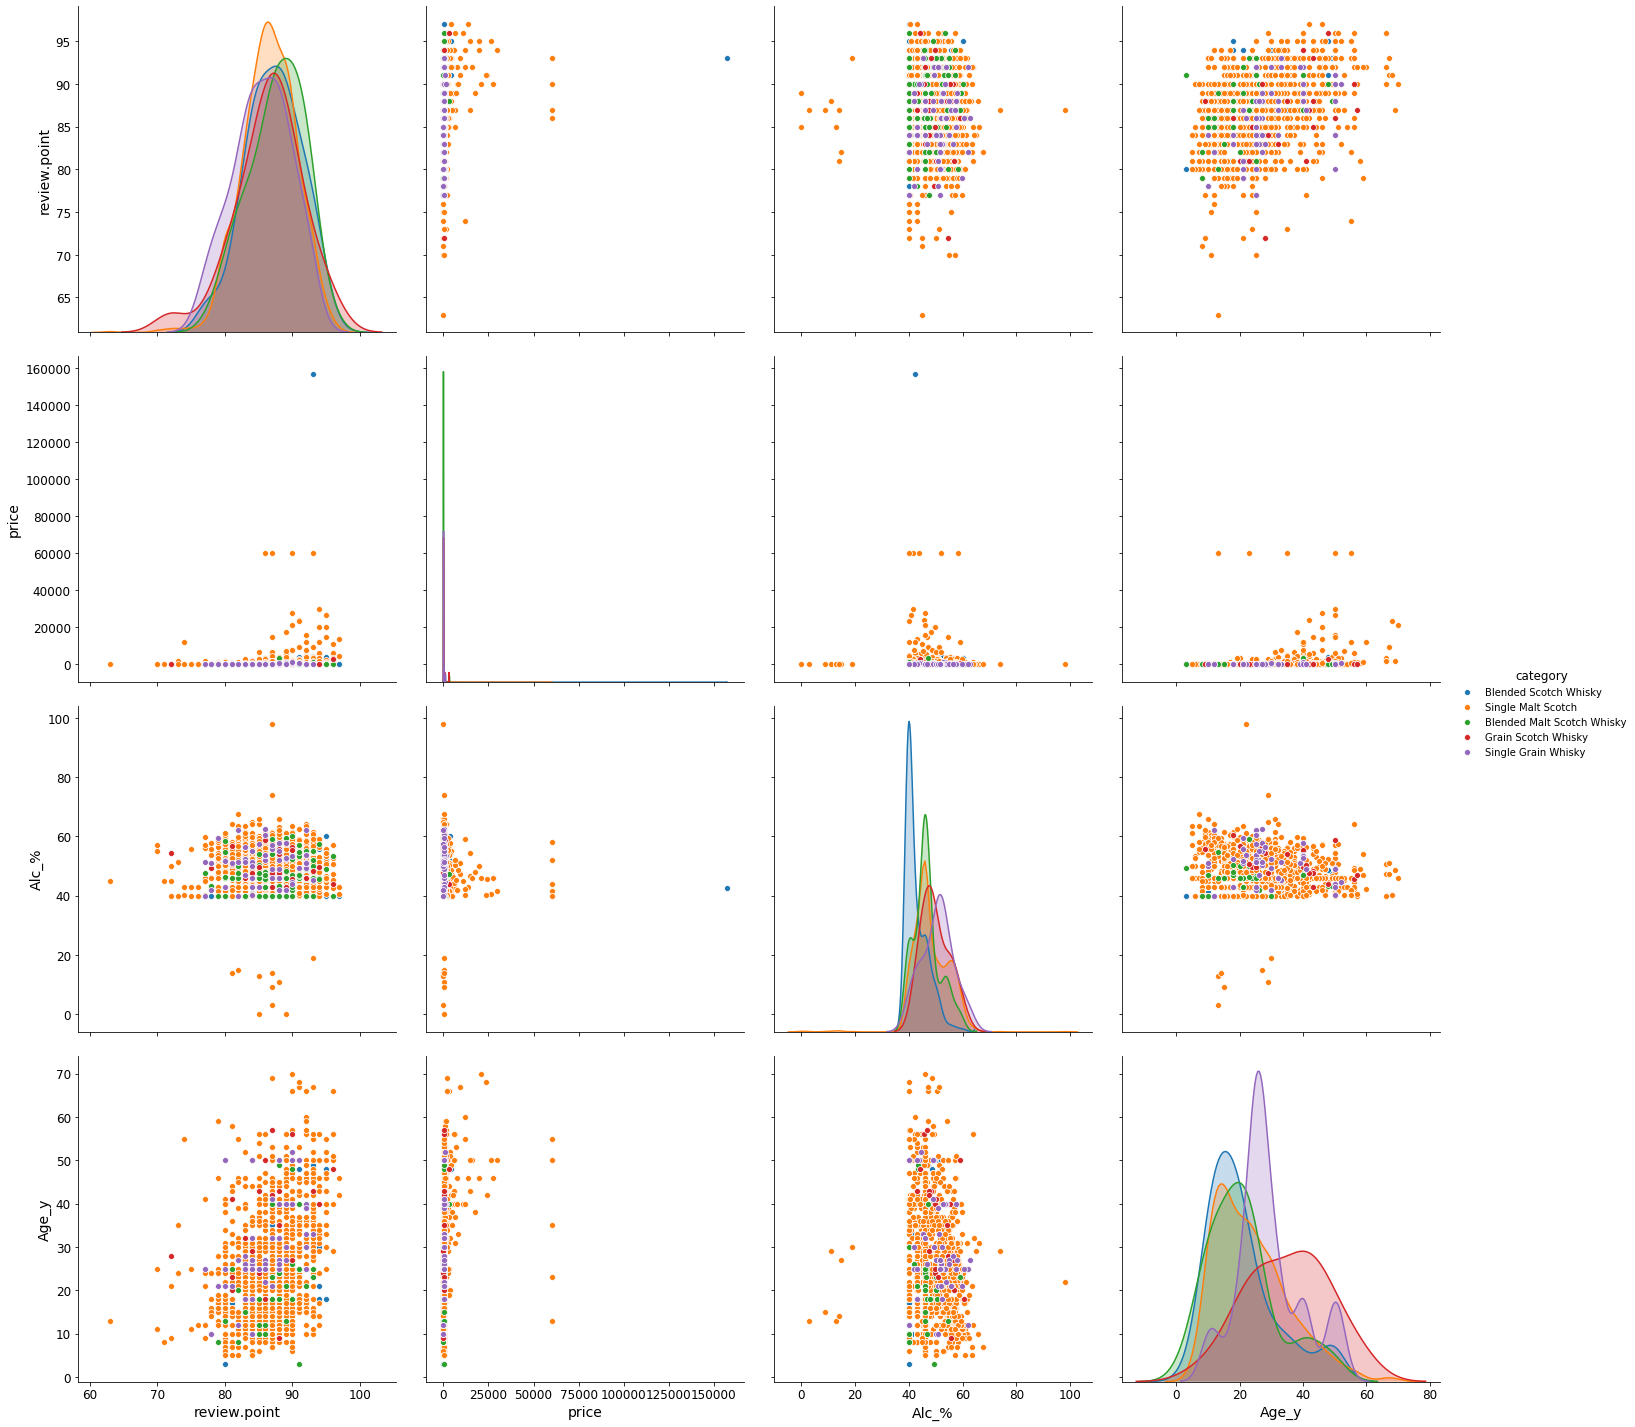

In [16]:
sns.pairplot(scotch, hue='category', size=5)

Observations:
- Blended Malt Scotch Whisky seems to be a little better rated as compared to the others
- Blended Scotch Whisky seems to have less alcohol % on average as compared to the others
- Grain Whisky is on average older than other categories

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79e5b41250>,
      dtype=object)

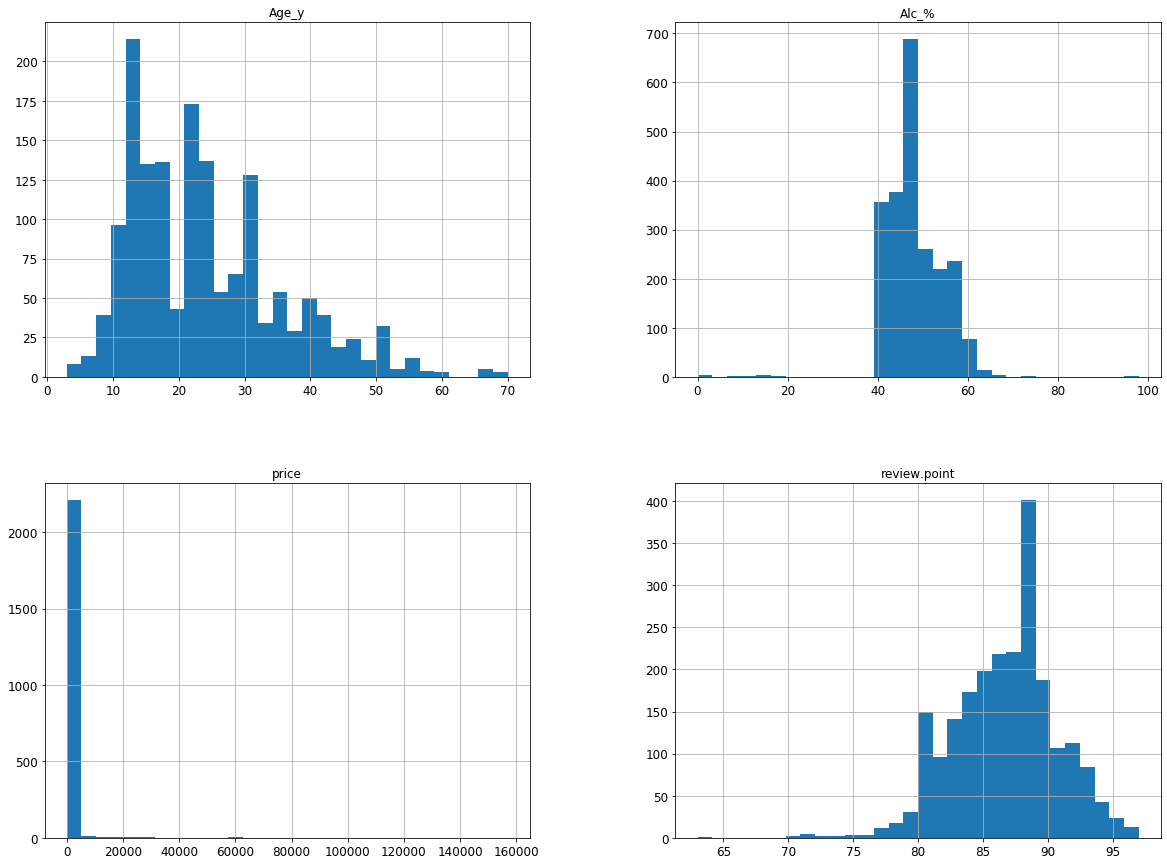

In [17]:
scotch.hist(bins=30, figsize=(20,15))

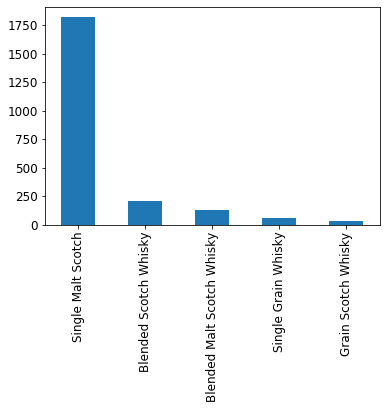

In [18]:
scotch[('category')].value_counts().plot(kind='bar')

### Final data clearing, viz and setup for ml

In [19]:
scotch.dropna(inplace=True)
scotch.drop(columns=['name', 'currency', 'description'], inplace=True)
scotch.reset_index(drop=True, inplace=True)
scotch.head(20)

,category,review.point,price,Alc_%,Age_y
0,Single Malt Scotch,97,4500.0,40.5,42.0
1,Single Malt Scotch,97,13500.0,42.9,46.0
2,Single Malt Scotch,96,6250.0,42.4,56.0
3,Single Malt Scotch,96,11000.0,44.8,40.0
4,Single Malt Scotch,96,1500.0,52.8,50.0
5,Single Malt Scotch,96,3360.0,47.2,66.0
6,Single Malt Scotch,96,750.0,50.8,51.0
7,Single Malt Scotch,96,1500.0,45.4,29.0
8,Grain Scotch Whisky,96,3108.0,44.0,48.0
9,Blended Scotch Whisky,95,70.0,40.0,18.0


In [20]:
scotch.describe()

,review.point,price,Alc_%,Age_y
count,1564.000000,1564.000000,1564.000000,1564.000000
mean,86.753836,762.698849,48.039834,24.003197
std,4.088295,3997.206773,6.518795,11.764238
min,63.000000,13.000000,3.000000,3.000000
25%,84.000000,80.000000,43.000000,15.000000
50%,87.000000,128.500000,46.000000,22.000000
75%,90.000000,270.000000,52.625000,30.000000
max,97.000000,60000.000000,98.000000,70.000000


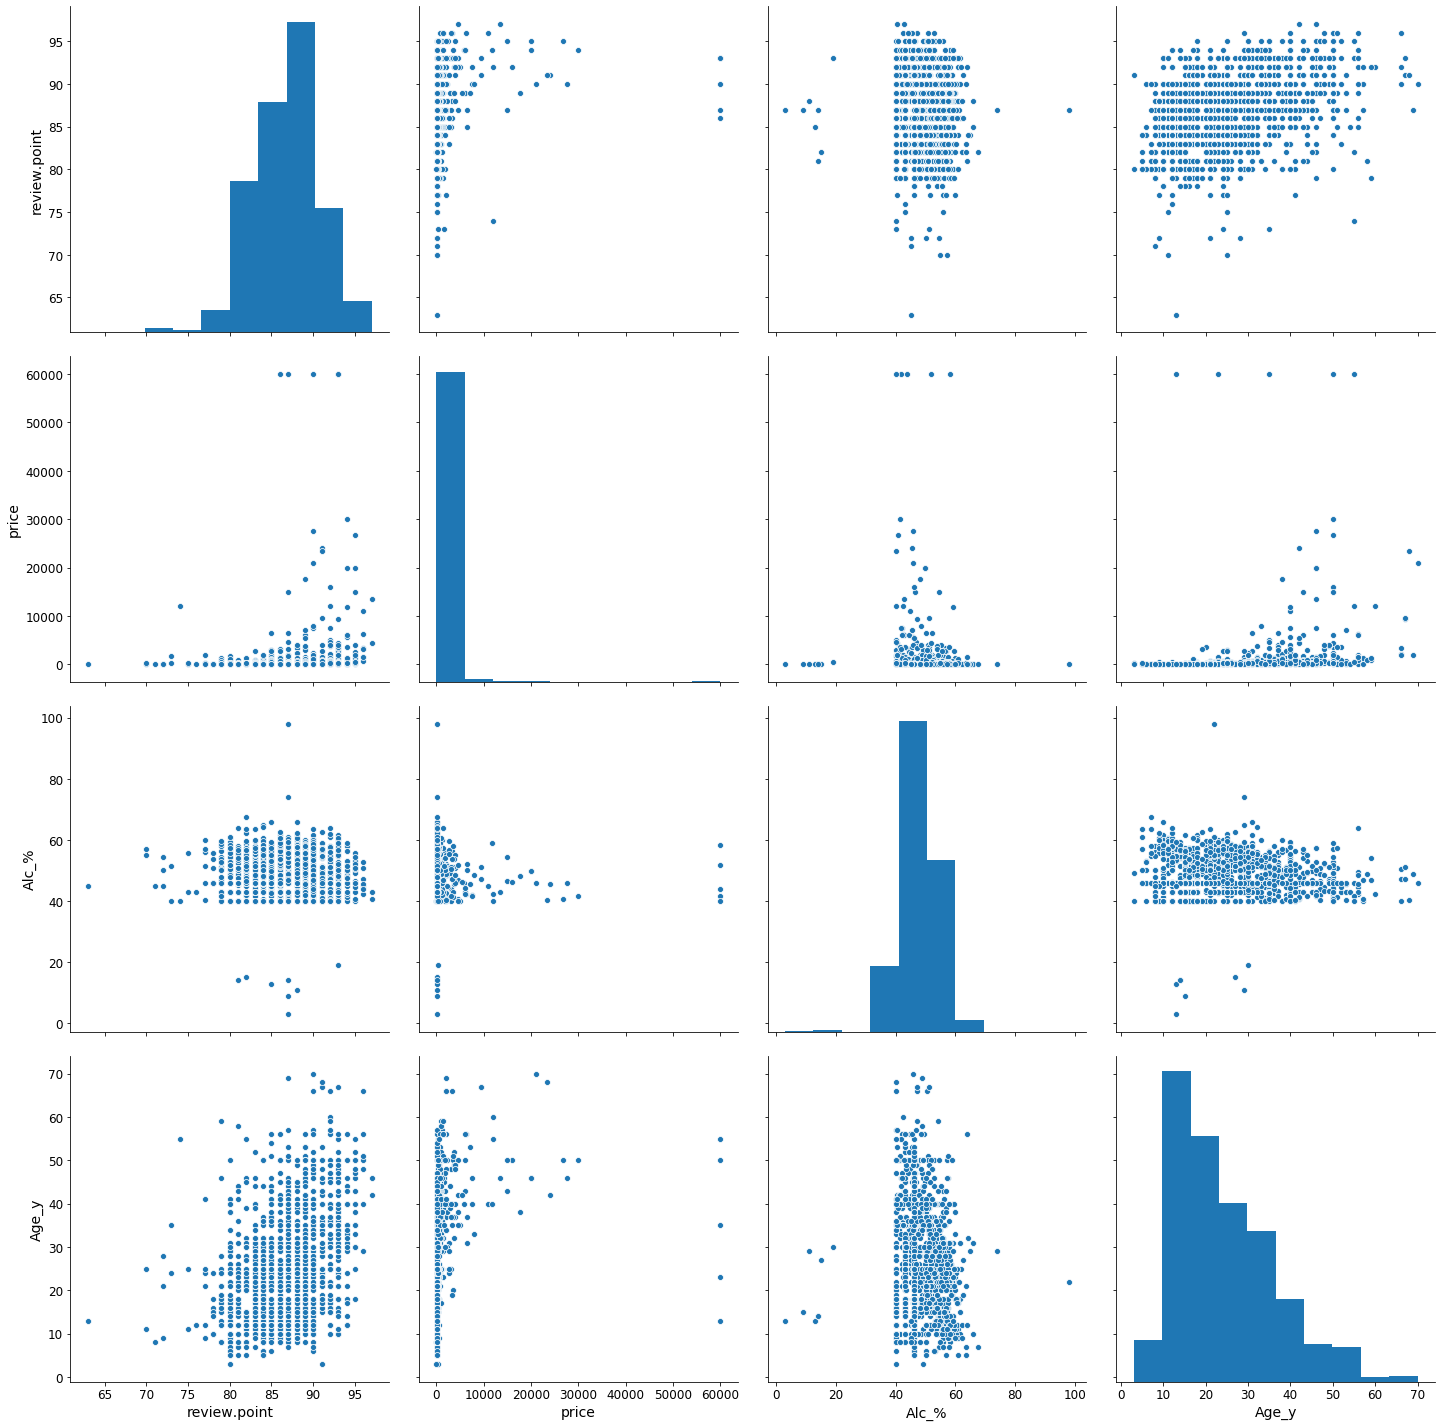

In [21]:
sns.pairplot(scotch, size=5)

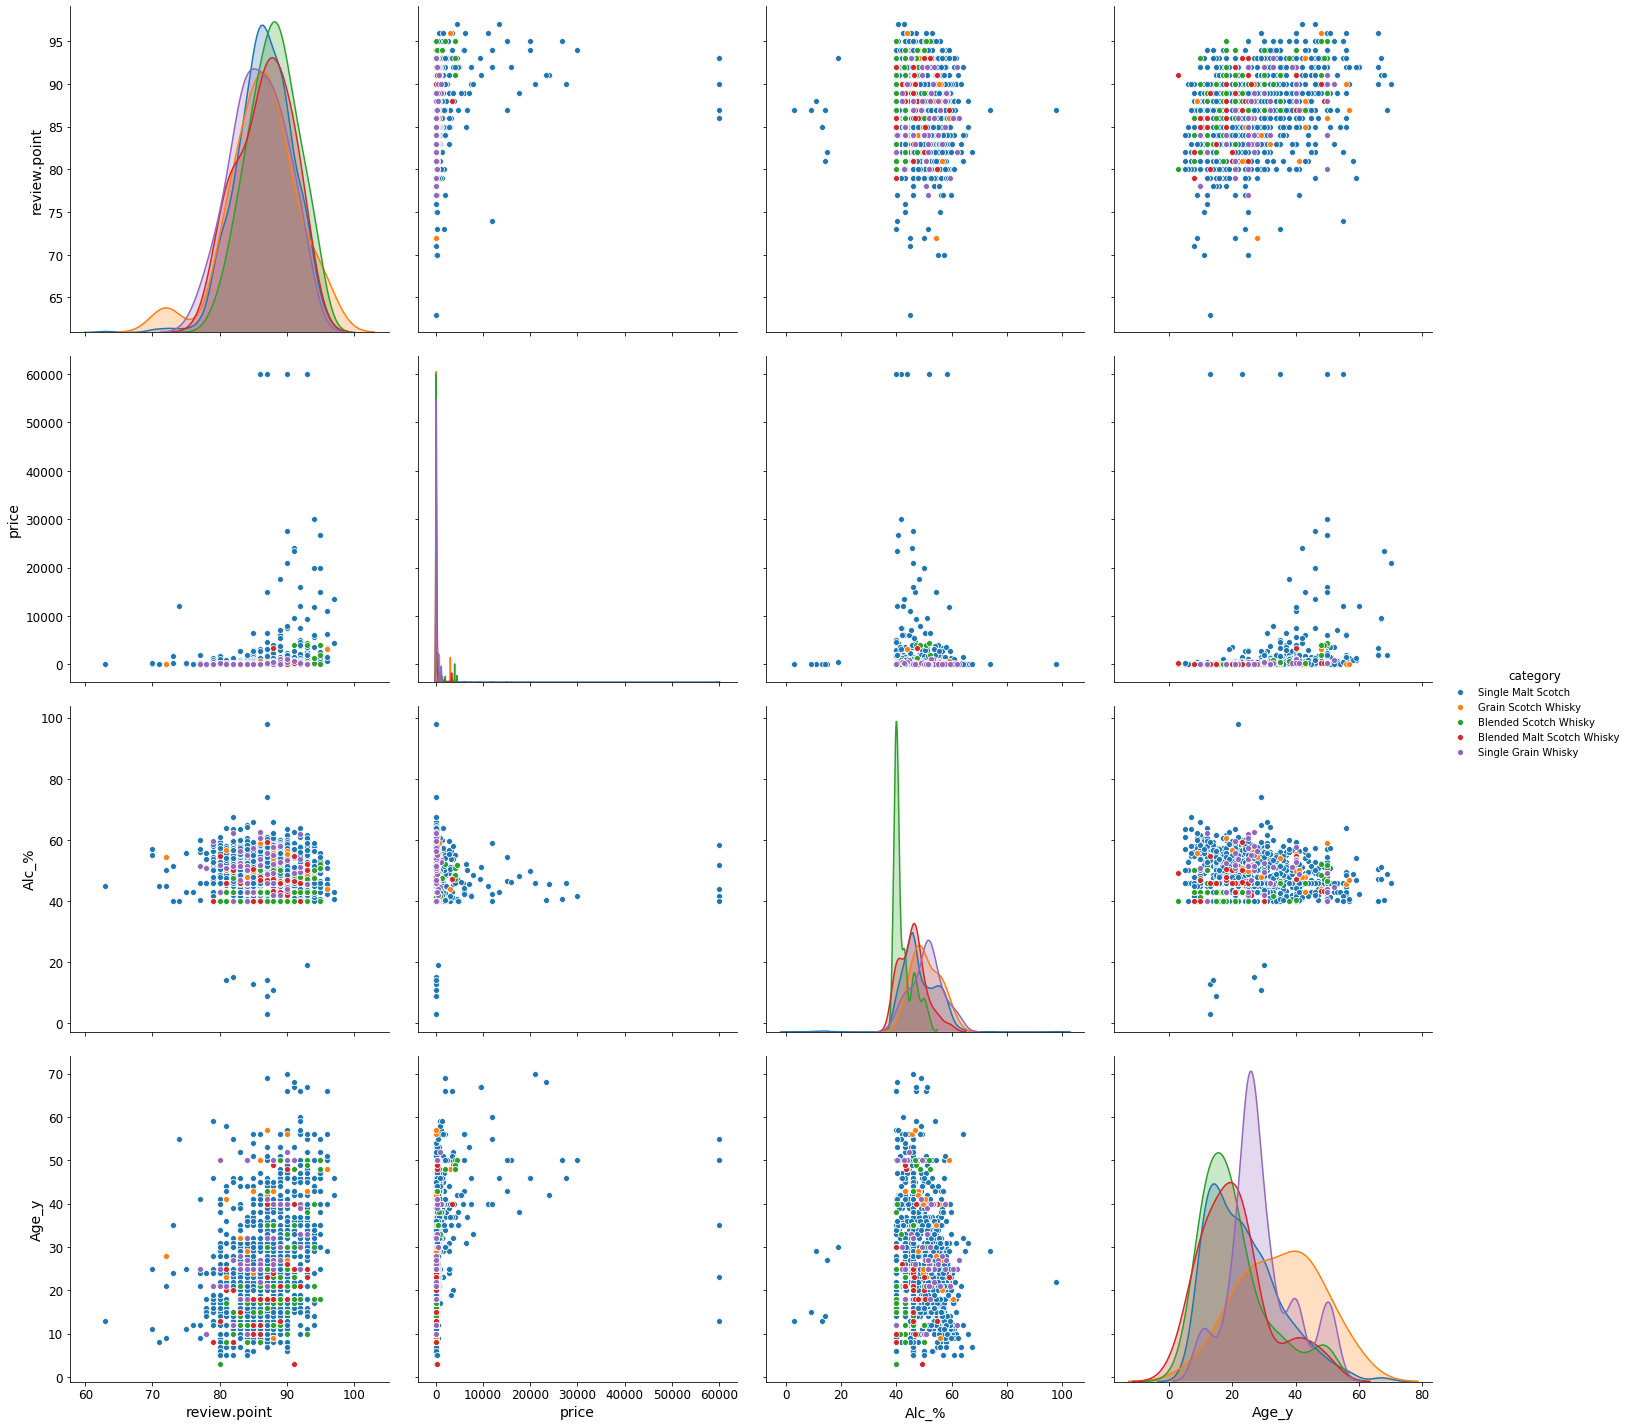

In [22]:
sns.pairplot(scotch, hue='category', size=5)

Observations:
- Blended Malt Scotch Whisky now is no longer better rated as compared to the others
- Blended Scotch Whisky seems to have less alcohol % on average as compared to the others
- Grain Whisky is on average older than other categories
- Feature "price" is still hard for interpretation; outliers present

In [23]:
save_fig("scotch_category")

Saving figure scotch_category


<Figure size 432x288 with 0 Axes>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79e1864a50>,
      dtype=object)

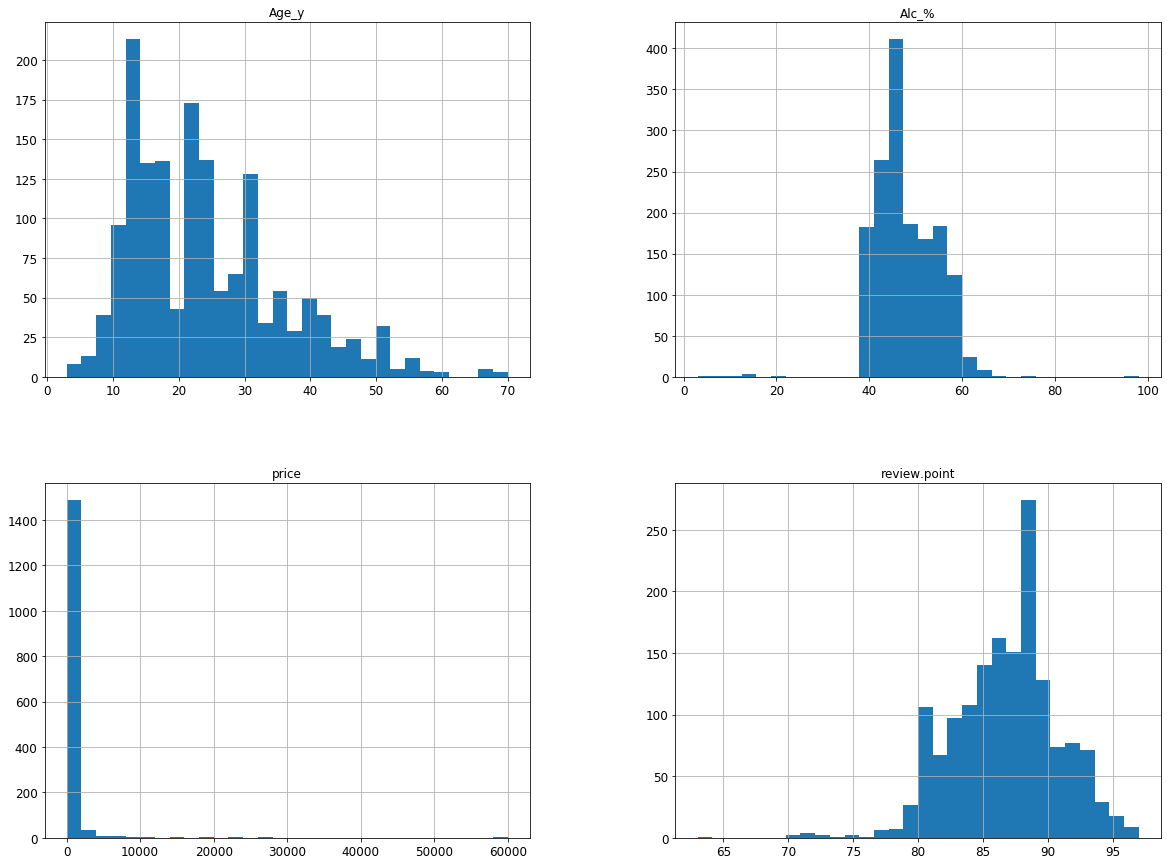

In [24]:
scotch.hist(bins=30, figsize=(20,15))

In [25]:
save_fig("scotch_attribute_hist")

Saving figure scotch_attribute_hist


<Figure size 432x288 with 0 Axes>

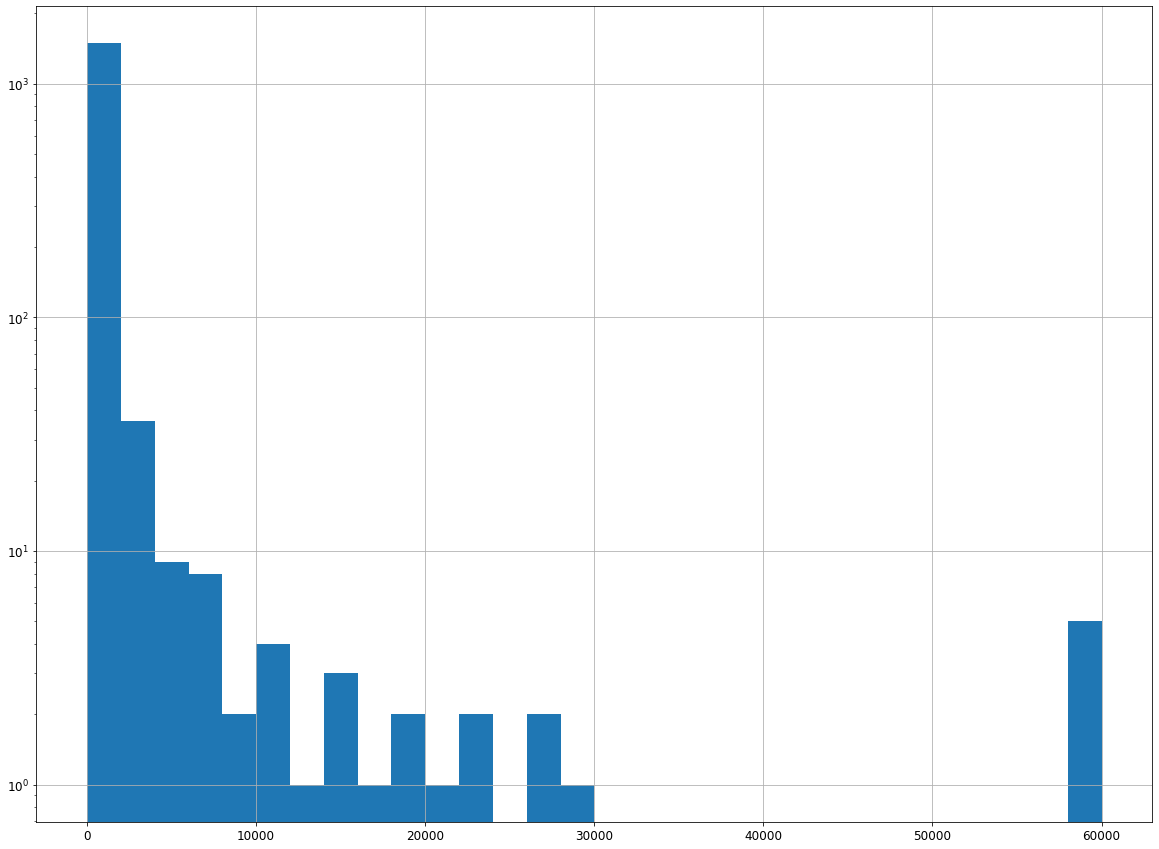

In [26]:
fig, ax = plt.subplots()
scotch['price'].hist(bins=30, figsize=(20,15))
ax.set_yscale('log')

In [27]:
save_fig("scotch_price_hist")

Saving figure scotch_price_hist


<Figure size 432x288 with 0 Axes>

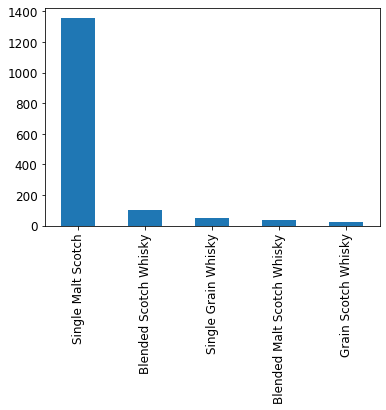

In [28]:
scotch[('category')].value_counts().plot(kind='bar')

In [29]:
save_fig("scotch_cat_valuecounts")

Saving figure scotch_cat_valuecounts


<Figure size 432x288 with 0 Axes>

In [30]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(scotch, test_size=0.2, random_state=4711)

test_set.head()

,category,review.point,price,Alc_%,Age_y
1267,Single Malt Scotch,83,140.0,44.1,40.0
1441,Single Malt Scotch,81,52.0,40.0,12.0
1223,Single Malt Scotch,84,125.0,46.0,24.0
491,Single Malt Scotch,89,485.0,54.4,34.0
782,Single Malt Scotch,87,240.0,46.7,37.0


In [31]:
scotch["rp_cat"] = pd.cut(scotch["review.point"],
                               bins=[0., 81., 85., 88., 92., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [32]:
scotch["rp_cat"].value_counts()

3    454
4    412
2    412
1    159
5    127
Name: rp_cat, dtype: int64

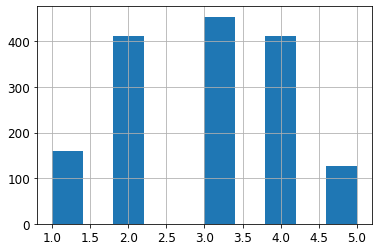

In [33]:
scotch["rp_cat"].hist()

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=4711)
for train_index, test_index in split.split(scotch, scotch["rp_cat"]):
    strat_train_set = scotch.reindex(train_index)
    strat_test_set = scotch.reindex(test_index)
    locstrat_train_set = scotch.loc[train_index]
    locstrat_test_set = scotch.loc[test_index]

In [35]:
strat_test_set.head()

,category,review.point,price,Alc_%,Age_y,rp_cat
270,Single Malt Scotch,91,280.0,57.1,22.0,4
409,Blended Scotch Whisky,89,160.0,43.0,23.0,4
348,Single Malt Scotch,90,60.0,43.0,15.0,4
698,Single Malt Scotch,87,93.0,46.0,23.0,3
1189,Single Malt Scotch,84,75.0,58.2,14.0,2


In [36]:
locstrat_test_set.head()

,category,review.point,price,Alc_%,Age_y,rp_cat
270,Single Malt Scotch,91,280.0,57.1,22.0,4
409,Blended Scotch Whisky,89,160.0,43.0,23.0,4
348,Single Malt Scotch,90,60.0,43.0,15.0,4
698,Single Malt Scotch,87,93.0,46.0,23.0,3
1189,Single Malt Scotch,84,75.0,58.2,14.0,2


In [37]:
strat_test_set["rp_cat"].value_counts() / len(strat_test_set)

3    0.290735
2    0.265176
4    0.261981
1    0.102236
5    0.079872
Name: rp_cat, dtype: float64

In [38]:
scotch["rp_cat"].value_counts() / len(scotch)

3    0.290281
4    0.263427
2    0.263427
1    0.101662
5    0.081202
Name: rp_cat, dtype: float64

In [39]:
def rp_cat_proportions(data):
    return data["rp_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(scotch, test_size=0.2, random_state=4711)

compare_props = pd.DataFrame({
    "Overall": rp_cat_proportions(scotch),
    "Stratified": rp_cat_proportions(strat_test_set),
    "Random": rp_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [40]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.101662,0.102236,0.102236,0.564631,0.564631
2,0.263427,0.265176,0.265176,0.663792,0.663792
3,0.290281,0.290735,0.261981,-9.749335,0.156226
4,0.263427,0.261981,0.271565,3.089426,-0.549024
5,0.081202,0.079872,0.099042,21.969259,-1.637695


In [41]:
scotch = strat_train_set.copy()

In [42]:
corr_matrix = scotch.corr()

In [43]:
corr_matrix["price"].sort_values(ascending=False) #target is price

price           1.000000
Age_y           0.245150
review.point    0.152618
Alc_%          -0.008842
Name: price, dtype: float64

Question: Should the stratification be done on Age_y rather than on review.point???
For now, let's postpone that question

Saving figure scatter_matrix_plot


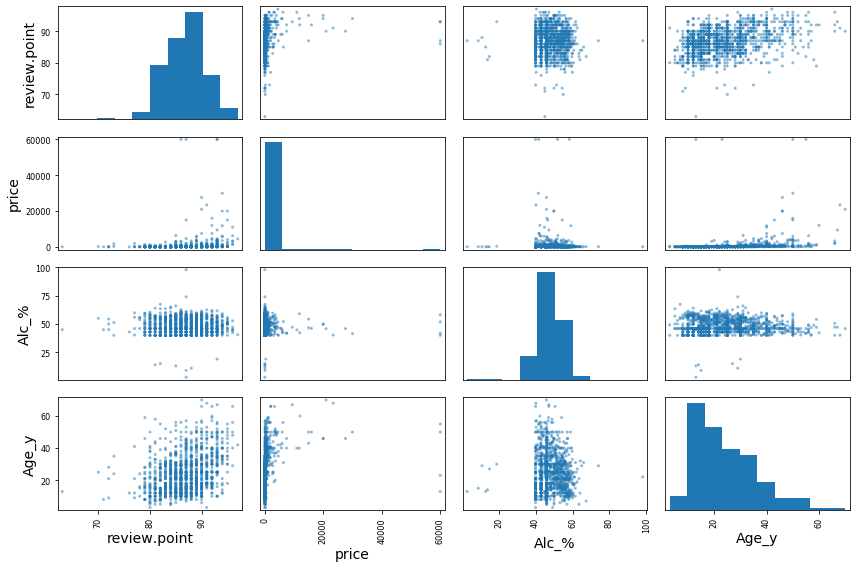

In [44]:
from pandas.plotting import scatter_matrix

attributes = ["review.point", "price", "Alc_%",
              "Age_y"]
scatter_matrix(scotch[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [45]:
strat_train_set.drop('rp_cat', axis=1, inplace=True)

In [46]:
scotch = strat_train_set.drop("price", axis=1) # drop target for training set
scotch_labels = strat_train_set["price"].copy()

In [47]:
scotch.head()

,category,review.point,Alc_%,Age_y
1250,Single Malt Scotch,83,46.0,16.0
1346,Single Malt Scotch,82,57.5,11.0
841,Single Malt Scotch,86,46.0,22.0
221,Single Malt Scotch,91,44.6,34.0
262,Blended Malt Scotch Whisky,91,46.5,25.0


let's process the categorial feature 

In [48]:
scotch_cat = scotch[["category"]]
scotch_cat.head(10)

,category
1250,Single Malt Scotch
1346,Single Malt Scotch
841,Single Malt Scotch
221,Single Malt Scotch
262,Blended Malt Scotch Whisky
1222,Single Malt Scotch
1325,Single Malt Scotch
620,Single Malt Scotch
420,Single Malt Scotch
1021,Single Malt Scotch


In [49]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
scotch_cat_1hot = cat_encoder.fit_transform(scotch_cat)
scotch_cat_1hot

<1251x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1251 stored elements in Compressed Sparse Row format>

In [50]:
scotch_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [51]:
cat_encoder = OneHotEncoder(sparse=False)
scotch_cat_1hot = cat_encoder.fit_transform(scotch_cat)
scotch_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [52]:
cat_encoder.categories_

[array(['Blended Malt Scotch Whisky', 'Blended Scotch Whisky',
        'Grain Scotch Whisky', 'Single Grain Whisky', 'Single Malt Scotch'],
       dtype=object)]

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rp_ix, alc_ix, age_ix = 1, 2, 3

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_rp_by_age = True): # no *args or **kargs
        self.add_rp_by_age = add_rp_by_age
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.add_rp_by_age:
            rp_by_age = X[:, rp_ix] / X[:, age_ix]
            return np.c_[X, rp_by_age]
        else:
            return np.c_[X]

attr_adder = CombinedAttributesAdder(add_rp_by_age=True)
scotch_extra_attribs = attr_adder.transform(scotch.values)
scotch_extra_attribs

array([['Single Malt Scotch', 83, 46.0, 16.0, 5.1875],
       ['Single Malt Scotch', 82, 57.5, 11.0, 7.454545454545454],
       ['Single Malt Scotch', 86, 46.0, 22.0, 3.909090909090909],
       ...,
       ['Single Malt Scotch', 86, 58.5, 13.0, 6.615384615384615],
       ['Single Malt Scotch', 87, 40.0, 10.0, 8.7],
       ['Single Malt Scotch', 90, 43.0, 17.0, 5.294117647058823]],
      dtype=object)

In [54]:
scotch_extra_attribs = pd.DataFrame(
    scotch_extra_attribs,
    columns=list(scotch.columns)+["review.points_by_age"],
    index=scotch.index)
scotch_extra_attribs.head()

,category,review.point,Alc_%,Age_y,review.points_by_age
1250,Single Malt Scotch,83,46,16,5.1875
1346,Single Malt Scotch,82,57.5,11,7.45455
841,Single Malt Scotch,86,46,22,3.90909
221,Single Malt Scotch,91,44.6,34,2.67647
262,Blended Malt Scotch Whisky,91,46.5,25,3.64


Now let's build a pipeline for preprocessing the numerical attributes:

In [55]:
scotch_num = scotch.drop(["category"], axis=1)
scotch_num.dtypes

review.point      int64
Alc_%           float64
Age_y           float64
dtype: object

In [56]:
scotch_num.values

array([[83. , 46. , 16. ],
       [82. , 57.5, 11. ],
       [86. , 46. , 22. ],
       ...,
       [86. , 58.5, 13. ],
       [87. , 40. , 10. ],
       [90. , 43. , 17. ]])

In [57]:
scotch_num.iloc[:,0]

1250    83
1346    82
841     86
221     91
262     91
        ..
388     90
931     86
917     86
783     87
330     90
Name: review.point, Length: 1251, dtype: int64

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

rp_ix, alc_ix, age_ix = 0, 1, 2

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

scotch_num_tr = num_pipeline.fit_transform(scotch_num)

In [59]:
scotch_num_tr

array([[-0.92314011, -0.30322854, -0.68222869,  0.2338364 ],
       [-1.16833083,  1.44480698, -1.10667074,  1.13490549],
       [-0.18756796, -0.30322854, -0.17289822, -0.27428527],
       ...,
       [-0.18756796,  1.59681007, -0.93689392,  0.80136922],
       [ 0.05762276, -1.21524708, -1.19155915,  1.62992891],
       [ 0.79319491, -0.75923781, -0.59734027,  0.27621308]])

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = list(scotch_num)
cat_attribs = ["category"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

scotch_prepared = full_pipeline.fit_transform(scotch)

In [61]:
scotch_prepared

array([[-0.92314011, -0.30322854, -0.68222869, ...,  0.        ,
         0.        ,  1.        ],
       [-1.16833083,  1.44480698, -1.10667074, ...,  0.        ,
         0.        ,  1.        ],
       [-0.18756796, -0.30322854, -0.17289822, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.18756796,  1.59681007, -0.93689392, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.05762276, -1.21524708, -1.19155915, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.79319491, -0.75923781, -0.59734027, ...,  0.        ,
         0.        ,  1.        ]])

In [62]:
scotch_prepared.shape

(1251, 9)

### Select and train a model (first linear regression)

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(scotch_prepared, scotch_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Execute full preprocessing pipeline on a few training instances

In [64]:
some_data = scotch.iloc[:5]
some_labels = scotch_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [-235.98609905 -309.68385882  344.01781068 1814.94539386  318.58797584]


Compare to actual values

In [65]:
print("Labels:", list(some_labels))

Labels: [113.0, 88.0, 70.0, 1100.0, 329.0]


Uff, this is not a good performance!

In [66]:
some_data_prepared

array([[-0.92314011, -0.30322854, -0.68222869,  0.2338364 ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [-1.16833083,  1.44480698, -1.10667074,  1.13490549,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [-0.18756796, -0.30322854, -0.17289822, -0.27428527,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 1.03838563, -0.51603287,  0.84576272, -0.76420755,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 1.03838563, -0.227227  ,  0.08176701, -0.38123924,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [67]:
from sklearn.metrics import mean_squared_error

scotch_predictions = lin_reg.predict(scotch_prepared)
lin_mse = mean_squared_error(scotch_labels, scotch_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3764.4202225562144

In [68]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(scotch_labels, scotch_predictions)
lin_mae

1002.772736675773

### Decission tree regressor

In [69]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=4711)
tree_reg.fit(scotch_prepared, scotch_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=4711, splitter='best')

In [70]:
scotch_predictions = tree_reg.predict(scotch_prepared)
tree_mse = mean_squared_error(scotch_labels, scotch_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

28.92653069400028

decission tree regressor works much better! Is there an overfitting issue?

### Fine tuning of models

scores are in the sense of a value, the bigger the better (opposite of mse); tree_rmse_scores uses the "-" such that we have the situation that the smaller the better; try a five-fold cross validation  

In [71]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, scotch_prepared, scotch_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [72]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [6797.30241839 2565.70772565 6836.5267292  4663.10657508 1301.67675843]
Mean: 4432.8640413499
Standard deviation: 2223.1410791080693


In [73]:
lin_scores = cross_val_score(lin_reg, scotch_prepared, scotch_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [5603.45126538 1752.27212693 4177.25142057 4363.80628821 1099.2862332 ]
Mean: 3399.213466858153
Standard deviation: 1696.8516551601324


the five-fold cross-validation shows that the decission tree regressor is worse than the linear regressor 

try one more regressor, a Random Forrest Regressor (= ensemble learning)

In [74]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=4711)
forest_reg.fit(scotch_prepared, scotch_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=4711,
                      verbose=0, warm_start=False)

In [75]:
scotch_predictions = forest_reg.predict(scotch_prepared)
forest_mse = mean_squared_error(scotch_labels, scotch_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1495.6645005051648

In [76]:
forest_scores = cross_val_score(forest_reg, scotch_prepared, scotch_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [5980.10682455 2409.03589116 4824.56755049 4240.89295821 1047.50989815]
Mean: 3700.422624513113
Standard deviation: 1758.3171316295561


the linear regressor is still the best!

In [77]:
scores = cross_val_score(lin_reg, scotch_prepared, scotch_labels, scoring="neg_mean_squared_error", cv=5)
pd.Series(np.sqrt(-scores)).describe()

count       5.000000
mean     3399.213467
std      1897.137824
min      1099.286233
25%      1752.272127
50%      4177.251421
75%      4363.806288
max      5603.451265
dtype: float64

Do a grid search for best params on a regressor (here: random forrest regressor)!

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [1, 2, 3]},
  ]

forest_reg = RandomForestRegressor(random_state=4711)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(scotch_prepared, scotch_labels)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=4711,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [1, 2, 3, 4],


In [79]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [80]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=4711,
                      verbose=0, warm_start=False)

closer look at the score of each hyperparameter combination tested during the grid search

In [81]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4241.746629762219 {'max_features': 1, 'n_estimators': 3}
3899.5369119439524 {'max_features': 1, 'n_estimators': 10}
3893.1705359127545 {'max_features': 1, 'n_estimators': 30}
4462.360996574646 {'max_features': 2, 'n_estimators': 3}
4114.3593494883435 {'max_features': 2, 'n_estimators': 10}
3828.911627006866 {'max_features': 2, 'n_estimators': 30}
4906.054853934333 {'max_features': 3, 'n_estimators': 3}
4095.1999905905386 {'max_features': 3, 'n_estimators': 10}
3963.017993400362 {'max_features': 3, 'n_estimators': 30}
4365.898325698945 {'max_features': 4, 'n_estimators': 3}
4018.8917448981015 {'max_features': 4, 'n_estimators': 10}
3857.5730139297293 {'max_features': 4, 'n_estimators': 30}
4701.097723046871 {'bootstrap': False, 'max_features': 1, 'n_estimators': 3}
4014.344572058257 {'bootstrap': False, 'max_features': 1, 'n_estimators': 10}
4002.171389401266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
3971.8207320612664 {'bootstrap': False, 'max_features': 2, 'n_estimato

so all results with a high number of n_estimators

In [82]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.020013,0.003768,0.001733,0.000235,1,3,NaN,"{'max_features': 1, 'n_estimators': 3}",-3.188793e+07,-9.527987e+06,...,-1.799241e+07,7.748831e+06,13,-6.217588e+06,-6.399154e+06,-2.755334e+06,-3.810371e+06,-6.992317e+06,-5.234953e+06,1.648467e+06
1,0.052887,0.004735,0.002832,0.000050,1,10,NaN,"{'max_features': 1, 'n_estimators': 10}",-3.346866e+07,-4.487539e+06,...,-1.520639e+07,1.108739e+07,4,-3.393670e+06,-4.384592e+06,-4.140197e+06,-3.394258e+06,-3.776336e+06,-3.817811e+06,3.965314e+05
2,0.146648,0.004831,0.006308,0.000195,1,30,NaN,"{'max_features': 1, 'n_estimators': 30}",-3.209969e+07,-3.336124e+06,...,-1.515678e+07,1.052658e+07,3,-1.473446e+06,-3.027998e+06,-2.350815e+06,-2.347373e+06,-2.396650e+06,-2.319256e+06,4.950728e+05
3,0.016759,0.000147,0.001415,0.000021,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.294404e+07,-8.970432e+06,...,-1.991267e+07,9.550229e+06,15,-5.547951e+06,-5.705081e+06,-5.081306e+06,-4.581777e+06,-4.855197e+06,-5.154263e+06,4.197366e+05
4,0.050776,0.000345,0.002705,0.000089,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.441914e+07,-3.472520e+06,...,-1.692795e+07,1.118174e+07,11,-3.313261e+06,-4.910400e+06,-4.403897e+06,-3.398175e+06,-3.777934e+06,-3.960733e+06,6.111249e+05
5,0.149257,0.003558,0.006288,0.000095,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.375797e+07,-3.277566e+06,...,-1.466056e+07,1.096857e+07,1,-1.758518e+06,-3.055184e+06,-2.406564e+06,-2.393748e+06,-2.564892e+06,-2.435781e+06,4.151229e+05
6,0.017581,0.000294,0.001492,0.000193,3,3,NaN,"{'max_features': 3, 'n_estimators': 3}",-3.350560e+07,-9.011709e+06,...,-2.406937e+07,9.368857e+06,18,-5.403119e+06,-5.431822e+06,-3.715083e+06,-3.368950e+06,-5.519762e+06,-4.687747e+06,9.426511e+05
7,0.054481,0.000696,0.002694,0.000085,3,10,NaN,"{'max_features': 3, 'n_estimators': 10}",-3.390288e+07,-5.120050e+06,...,-1.677066e+07,1.077386e+07,10,-3.157846e+06,-4.754726e+06,-4.242312e+06,-3.237757e+06,-3.628258e+06,-3.804180e+06,6.107418e+05
8,0.161102,0.004199,0.006207,0.000131,3,30,NaN,"{'max_features': 3, 'n_estimators': 30}",-3.370579e+07,-4.251503e+06,...,-1.570551e+07,1.104063e+07,5,-1.617907e+06,-2.940853e+06,-2.167381e+06,-2.320055e+06,-2.508077e+06,-2.310855e+06,4.328143e+05
9,0.018907,0.000235,0.001427,0.000063,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.172519e+07,-6.722770e+06,...,-1.906107e+07,1.067906e+07,14,-5.907079e+06,-5.254112e+06,-2.737479e+06,-4.684781e+06,-4.880939e+06,-4.692878e+06,1.062853e+06


In [83]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=4711)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=4711)
rnd_search.fit(scotch_prepared, scotch_labels)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [84]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4037.770495126522 {'max_features': 5, 'n_estimators': 56}
3994.5738358337135 {'max_features': 7, 'n_estimators': 90}
3938.516239355607 {'max_features': 2, 'n_estimators': 148}
4001.578058571734 {'max_features': 5, 'n_estimators': 136}
3992.209904233333 {'max_features': 7, 'n_estimators': 79}
4013.6333158587477 {'max_features': 7, 'n_estimators': 128}
3926.285005163623 {'max_features': 1, 'n_estimators': 61}
3937.753950491974 {'max_features': 6, 'n_estimators': 90}
4007.0161259907927 {'max_features': 1, 'n_estimators': 140}
3980.5315411937318 {'max_features': 1, 'n_estimators': 107}


In [85]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.15266508, 0.34040409, 0.20372897, 0.27827525, 0.00060179,
       0.00569379, 0.00053349, 0.00331913, 0.0147784 ])

In [86]:
extra_attribs = ["review.points_by_age"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3404040917938244, 'Alc_%'),
 (0.27827524635840634, 'review.points_by_age'),
 (0.2037289744521323, 'Age_y'),
 (0.15266507924212816, 'review.point'),
 (0.014778401815499422, 'Single Malt Scotch'),
 (0.005693789833527207, 'Blended Scotch Whisky'),
 (0.00331913303621806, 'Single Grain Whisky'),
 (0.0006017887351723717, 'Blended Malt Scotch Whisky'),
 (0.0005334947330917613, 'Grain Scotch Whisky')]

In [87]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("price", axis=1)
y_test = strat_test_set["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [88]:
final_rmse

4172.17710555405

Compute 1 sigma confidence level for rsme

In [89]:
from scipy import stats

confidence = 0.68
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([2417.59205391, 5382.32034174])

calculation "by hand":

In [90]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(2417.59205390978, 5382.320341738406)

Alternatively, use a z-scores rather than t-scores:

In [91]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(2421.400054609734, 5380.608271910781)

In conclusion, the dataset is not very good for regression models, since too few parameters with a too wide spread are given. But maybe we can do better...

### Now do a full pipeline with optimized dataset

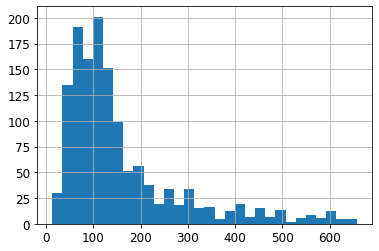

In [92]:
scotch=load_scotch_data()

scotch['Alc_%']=scotch['name'].progress_apply(get_alc)
scotch['Age_y_1']=scotch['name'].progress_apply(get_age)
scotch['Age_y_2']=scotch['name'].progress_apply(get_date)
scotch['Age_y']=scotch.progress_apply(lambda x: final_age(x['Age_y_1'],x['Age_y_2']),axis=1)
scotch['price']=scotch['price'].progress_apply(get_price)
scotch.drop('Unnamed: 0',axis=1,inplace=True)
scotch.drop('Age_y_1',axis=1,inplace=True)
scotch.drop('Age_y_2',axis=1,inplace=True)

scotch.drop(columns=['name', 'currency', 'description'], inplace=True)
scotch.dropna(subset=['price','review.point', 'Alc_%', 'Age_y'],inplace=True)
scotch[['review.point','Alc_%','Age_y']]=scotch[['review.point','Alc_%','Age_y']].astype(np.float32)

indexNames = scotch[(scotch['Alc_%'] <= 19.0)].index #delete complete outlayers
scotch.drop(indexNames, inplace=True)

indexNames = scotch[(scotch['Alc_%'] >= 70.0)].index #delete complete outlayers
scotch.drop(indexNames, inplace=True)

# Interquartile range
iqr = scotch['price'].describe()['75%'] - scotch['price'].describe()['25%']

# Remove outliers
scotch = scotch[(scotch['price'] > (scotch['price'].describe()['25%'] - 2 * iqr))]

scotch = scotch[(scotch['price'] < (scotch['price'].describe()['75%'] + 2 * iqr))]

scotch['price'].hist(bins=30)

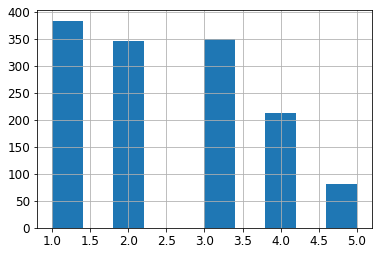

In [93]:
# Stratification
scotch["alc_cat"] = pd.cut(scotch["Alc_%"],
                               bins=[0., 43., 46., 54., 58., np.inf],
                               labels=[1, 2, 3, 4, 5])

scotch["alc_cat"].hist()

#scotch.reset_index(drop=True, inplace=True)

train_set, test_set = train_test_split(scotch, test_size=0.2, random_state=4711, stratify=scotch['alc_cat']) #stratify on Alc_%

In [94]:
scotch.describe()

,review.point,price,Alc_%,Age_y
count,1371.000000,1371.000000,1371.000000,1371.000000
mean,86.380745,158.719912,48.210720,21.703865
std,3.913784,127.286889,5.903553,9.825401
min,63.000000,13.000000,40.000000,3.000000
25%,84.000000,75.000000,43.000000,14.000000
50%,86.000000,119.000000,46.000000,21.000000
75%,89.000000,189.500000,52.900002,28.000000
max,95.000000,657.000000,67.400002,57.000000


In [95]:
np.any(np.isnan(scotch['price']))

False

In [96]:
np.any(np.isnan(scotch['Alc_%']))

False

In [97]:
np.all(np.isfinite(scotch['Alc_%']))

True

In [98]:
train_set.drop('alc_cat', axis=1, inplace=True)
X = train_set.drop("price", axis=1) # drop target for training set
Y = train_set["price"]

test_set.drop('alc_cat', axis=1, inplace=True)
Xt = test_set.drop("price", axis=1) # drop target for test set
Yt = test_set["price"]

# column index
rp_ix, alc_ix, age_ix = 0, 1, 2

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [99]:
X.iloc[:,1]

270     92.0
2111    80.0
2072    81.0
1057    87.0
1904    83.0
        ... 
1875    83.0
1978    82.0
442     90.0
949     88.0
646     89.0
Name: review.point, Length: 1096, dtype: float32

In [100]:
np.any(np.isnan(Y))

False

In [101]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

numeric_features = ['review.point', 'Alc_%', 'Age_y']
numeric_transformer = make_pipeline(SimpleImputer(missing_values=np.nan,strategy="median"),
                                    CombinedAttributesAdder(),
                                    StandardScaler())

categorical_features = ['category']
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'),
                                        OneHotEncoder(sparse = False, handle_unknown='ignore'))

preprocessor = make_column_transformer((numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features))

In [102]:
forest_reg = RandomForestRegressor(random_state=4711)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', forest_reg)])
sorted(clf.get_params().keys())

['classifier',
 'classifier__bootstrap',
 'classifier__criterion',
 'classifier__max_depth',
 'classifier__max_features',
 'classifier__max_leaf_nodes',
 'classifier__min_impurity_decrease',
 'classifier__min_impurity_split',
 'classifier__min_samples_leaf',
 'classifier__min_samples_split',
 'classifier__min_weight_fraction_leaf',
 'classifier__n_estimators',
 'classifier__n_jobs',
 'classifier__oob_score',
 'classifier__random_state',
 'classifier__verbose',
 'classifier__warm_start',
 'memory',
 'preprocessor',
 'preprocessor__n_jobs',
 'preprocessor__pipeline-1',
 'preprocessor__pipeline-1__combinedattributesadder',
 'preprocessor__pipeline-1__combinedattributesadder__add_rp_by_age',
 'preprocessor__pipeline-1__memory',
 'preprocessor__pipeline-1__simpleimputer',
 'preprocessor__pipeline-1__simpleimputer__add_indicator',
 'preprocessor__pipeline-1__simpleimputer__copy',
 'preprocessor__pipeline-1__simpleimputer__fill_value',
 'preprocessor__pipeline-1__simpleimputer__missing_values

In [103]:
clf.fit(X, Y)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                

In [104]:
print("model score: %.3f" % np.sqrt(-clf.score(Xt, Yt)))

model score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [105]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'classifier__n_estimators': [3, 10, 30], 'classifier__max_features': [1, 2, 3, 4]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'classifier__bootstrap': [False], 'classifier__n_estimators': [3, 10], 'classifier__max_features': [1, 2, 3]},
  ]

grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(Xt, Yt)

print(("best logistic regression from grid search (rfr_rsme_scores): %.3f"
       % np.sqrt(-grid_search.score(Xt, Yt))))

best logistic regression from grid search (rfr_rsme_scores): 46.137


In [106]:
grid_search.best_params_

{'classifier__max_features': 2, 'classifier__n_estimators': 30}